In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from typing import Dict, List
from scipy.stats import chi2_contingency
import os

In [20]:
# read data
data_train = pd.read_csv(os.path.join("raw", "train.csv"))
data_test = pd.read_csv(os.path.join("raw", "test.csv"))
data = pd.concat([data_train, data_test], sort=False)
display(data.head())
display(data.info())

,issue_area,issue_category,issue_sub_category,issue_category_sub_category,customer_sentiment,product_category,product_sub_category,issue_complexity,agent_experience_level,agent_experience_level_desc,conversation
0,Login and Account,Mobile Number and Email Verification,Verification requirement for mobile number or ...,Mobile Number and Email Verification -> Verifi...,neutral,Appliances,Oven Toaster Grills (OTG),medium,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox Customer...
1,Cancellations and returns,Pickup and Shipping,Reasons for being asked to ship the item,Pickup and Shipping -> Reasons for being asked...,neutral,Electronics,Computer Monitor,less,junior,"handles customer inquiries independently, poss...",Agent: Thank you for calling BrownBox customer...
2,Cancellations and returns,Replacement and Return Process,Inability to click the 'Cancel' button,Replacement and Return Process -> Inability to...,neutral,Appliances,Juicer/Mixer/Grinder,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for calling BrownBox Customer...
3,Login and Account,Login Issues and Error Messages,Error message regarding exceeded attempts to e...,Login Issues and Error Messages -> Error messa...,neutral,Appliances,Water Purifier,less,inexperienced,"may struggle with ambiguous queries, rely on c...","Customer: Hi, I am facing an issue while loggi..."
4,Order,Order Delivery Issues,Delivery not attempted again,Order Delivery Issues -> Delivery not attempte...,negative,Electronics,Bp Monitor,medium,experienced,"confidently handles complex customer issues, e...",Agent: Thank you for contacting BrownBox custo...


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 29
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   issue_area                   1000 non-null   object
 1   issue_category               1000 non-null   object
 2   issue_sub_category           1000 non-null   object
 3   issue_category_sub_category  1000 non-null   object
 4   customer_sentiment           1000 non-null   object
 5   product_category             1000 non-null   object
 6   product_sub_category         1000 non-null   object
 7   issue_complexity             1000 non-null   object
 8   agent_experience_level       1000 non-null   object
 9   agent_experience_level_desc  1000 non-null   object
 10  conversation                 1000 non-null   object
dtypes: object(11)
memory usage: 93.8+ KB


None

In [29]:
# non categorical columns and not necessary columns for analysis are dropped
columns = data.columns
categorical_columns = columns.drop(["issue_category_sub_category", "agent_experience_level_desc", "conversation", "issue_sub_category"])
print(f"Categorcal Colmuns are: {categorical_columns.values}")

Categorcal Colmuns are: ['issue_area' 'issue_category' 'customer_sentiment' 'product_category'
 'product_sub_category' 'issue_complexity' 'agent_experience_level']


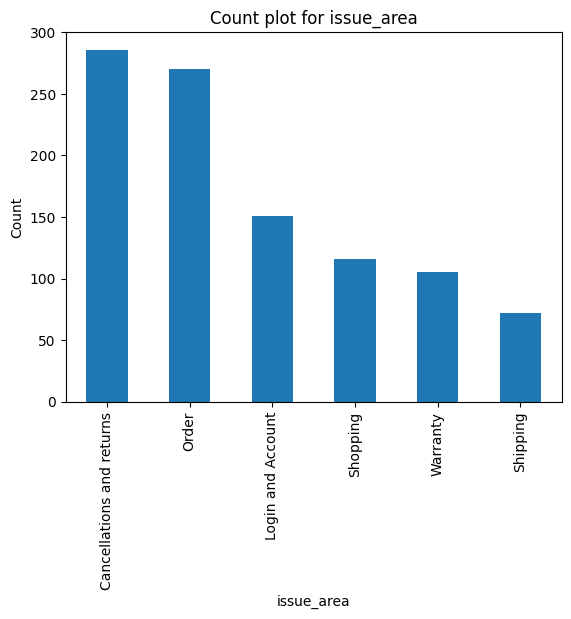

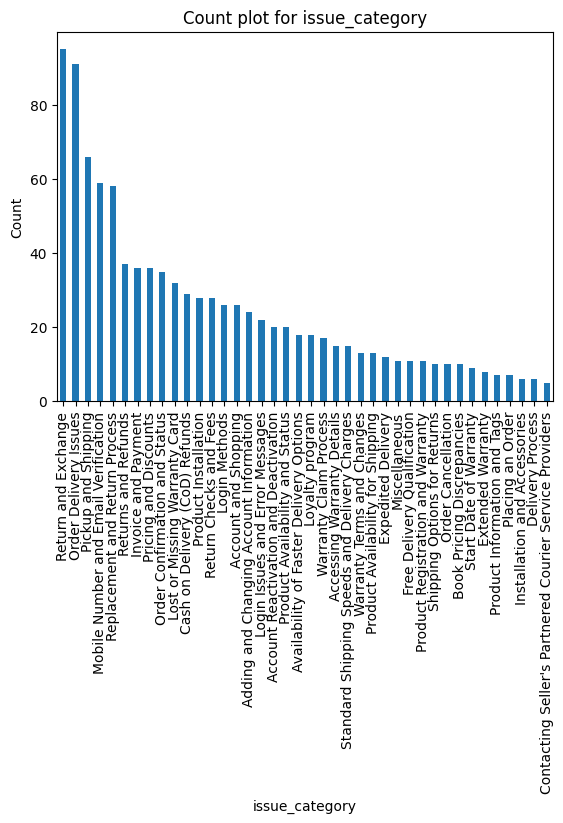

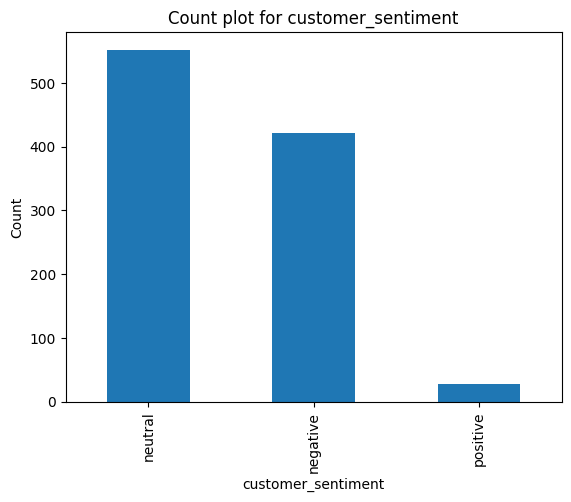

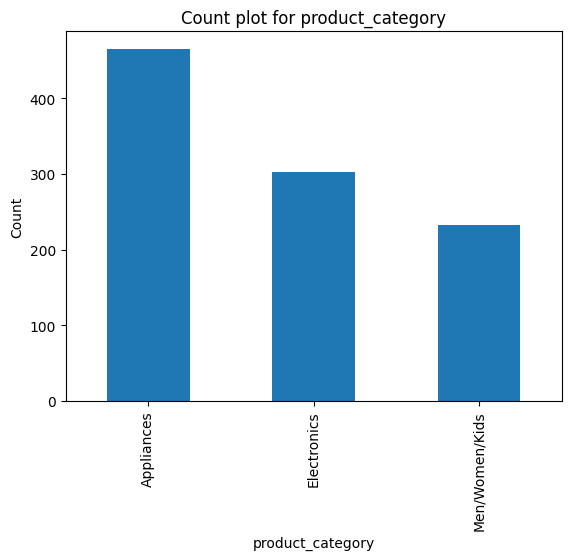

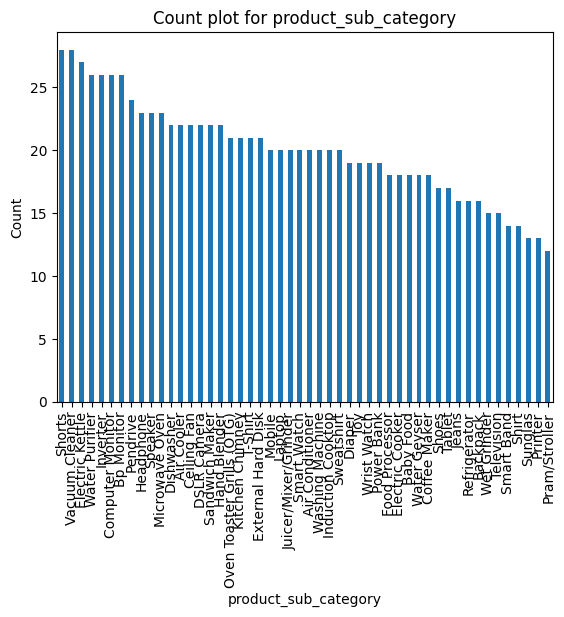

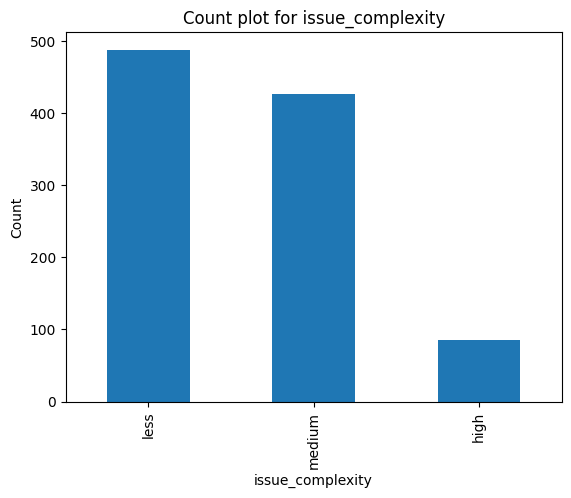

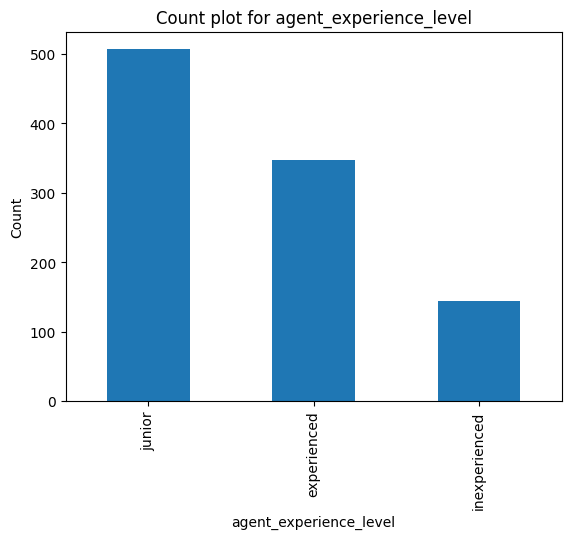

In [30]:
# visualization of categorical columns
for col in categorical_columns:
    data[col].value_counts().plot(kind='bar')
    plt.title(f"Count plot for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

In [43]:
def perform_chi_square_tests(
    df: pd.DataFrame,
    target_col: str,
    categorical_cols: List[str]
) -> pd.DataFrame:
    """
    Performs Chi-Square test of independence between each categorical column and the target column.

    Args:
        df (pd.DataFrame): Input DataFrame containing categorical columns.
        target_col (str): Name of the target categorical column.
        categorical_cols (List[str]): List of categorical columns to test against the target.

    Returns:
        pd.DataFrame: DataFrame containing p-values and chi-square statistics for each feature.
    """
    results: Dict[str, Dict[str, float]] = {}

    for col in categorical_cols:
        if target_col == col:
            continue
        contingency_table = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, _ = chi2_contingency(contingency_table)
        results[col] = {
            "p_value": p,
            "is_rejected": p < 0.05,
        }

    return pd.DataFrame(results).T.sort_values(by="p_value")


In [44]:
chi_results = perform_chi_square_tests(data, target_col="customer_sentiment", categorical_cols=categorical_columns)
display(chi_results)

,p_value,is_rejected
issue_category,0.0,True
issue_area,0.0,True
agent_experience_level,0.04593,True
product_category,0.611141,False
issue_complexity,0.69316,False
product_sub_category,0.942867,False


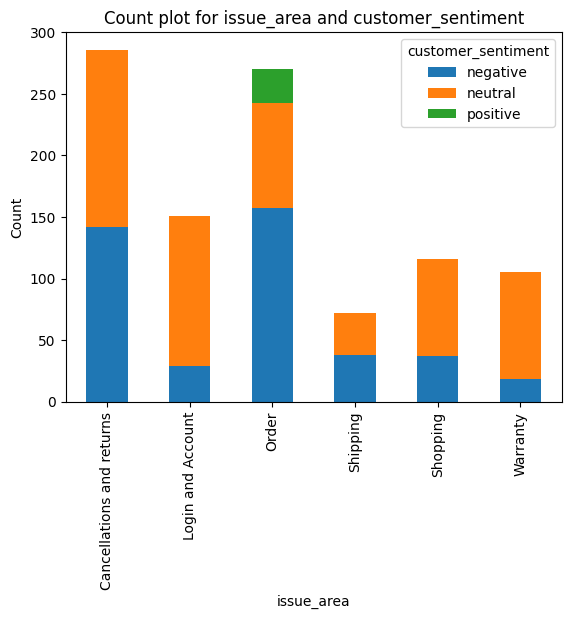

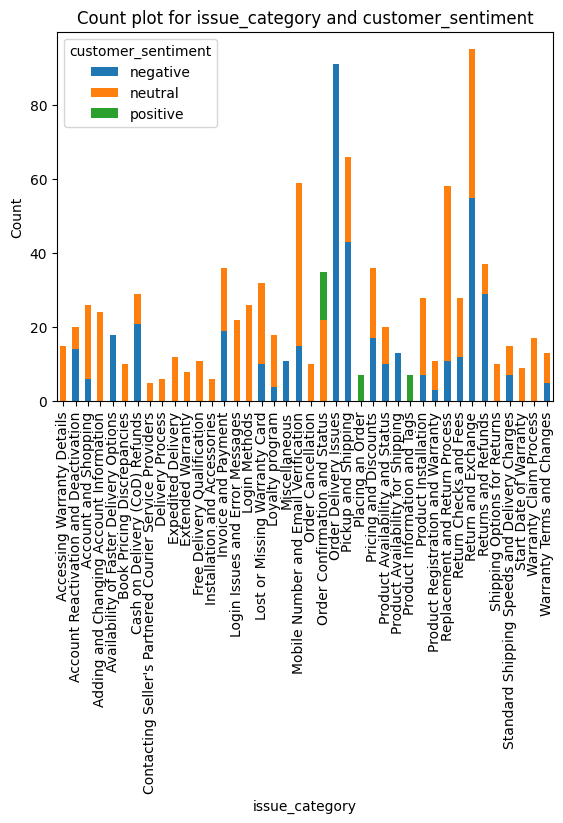

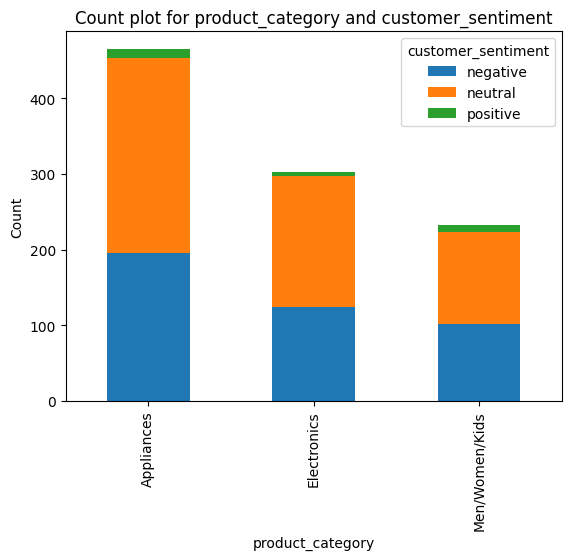

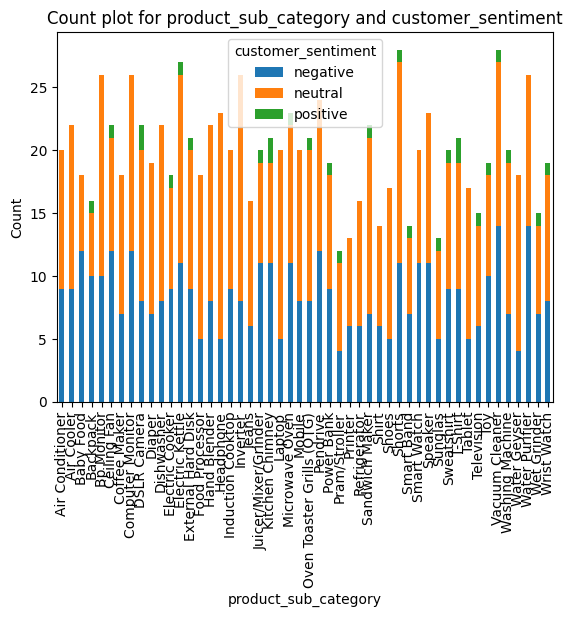

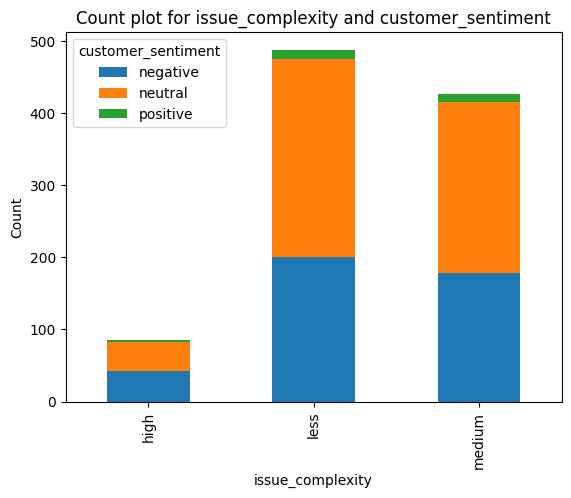

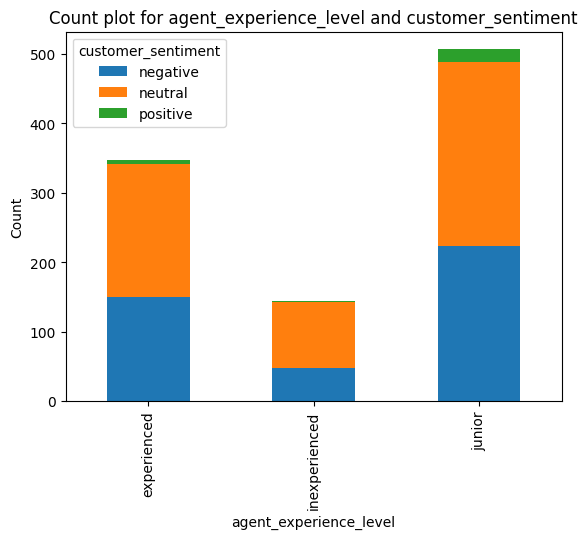

In [42]:
# comparing customer_sentiment with other columns
for col in categorical_columns:
    if col != "customer_sentiment":
        data.groupby([col, "customer_sentiment"]).size().unstack().plot(kind='bar', stacked=True)
        plt.title(f"Count plot for {col} and customer_sentiment")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

Here, we see that agent_experience_level, issue_category and issue_sub_category are significant columns for customer_sentiment 
- For instance, Accessing Warrant Details, Book Pricing Discrepancy, Cash On Delivery Refunds, etc. has only neutral sentiment. Likewise, Pickup and Shipping,Product information and tags categories have only positive sentiment.
- So, we can say that these columns are significant for customer_sentiment
- We also can conclude from the distribution of customer_sentiment that the data is imbalanced. We have more neutral and negative sentiments than positive sentiments. So, we must be careful while training the model and not to overfit the model to the majority class.